<a href="https://colab.research.google.com/github/Yohoh/one-pixel-attack-keras/blob/master/one_pixel_attack_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# One Pixel Attack Tutorial
## Part 1 - Cifar10

### Dan Kondratyuk
### September 15, 2019

# Übung
# One Pixel Attack
## auf Basis des Cifar10 Datasets

### Yannis Heim

In diesem Colab Script soll verdeutlicht werden wie ein Angriff gegen eine Bilderkennungs KI durchgeführt werden kann.
Gezeigt wird dies am Beispiel eines One Pixel Attack welches in diesem [Paper](https://arxiv.org/abs/1710.08864) beschrieben ist.

Dabei werden die einzelnen Schritte erläutert die nötig sind.

![](images/pred2.png "All it takes is one pixel")

This notebook will demonstrate the one pixel attack with a few different convolutional neural network models. By using differential evolution, we find a special pixel that can modify a target image such that the network misclassifies the image (which it previously correctly classified).

In theory, we want models that don't get fooled by such tiny changes. Especially in images, it is undesirable to have a small alteration in the input result in a drastic change in the output. However, even the most accurate neural networks are susceptible to this type of attack.

To read more about it, see [the original paper](https://arxiv.org/abs/1710.08864), or the authors' [official repo](https://github.com/Carina02/One-Pixel-Attack).

Let's get started.

Bevor wir loslegen können muss sichergesetellt sein dass das Colab Skript mit einer GPU Runtime gestartet wird.
Dazu muss der Laufzeittyp geändert werden.


It is recommended to use Keras with a GPU enabled. If you're [running in Google Colab](https://colab.research.google.com/drive/1Zq1kGP9C7i-70-SXyuEEaqYngtyQZMn7), you can enable a GPU instance by selecting `Runtime > Change runtime type > Hardware accelerator > GPU` (you will need to re-run all cells). The code below can be used to check (if using TensorFlow).

Öffnet dazu das Drop-down Menu bei Verbinden und wählt "Ressourcen ansehen".
Wählt dort "Laufzeittyp ändern" aus und stellt dort als Hardwarebeschleunigung GPU aus und speichert die Einstellung.

Nun kanns losgehen!

## Imports

Zuerst müssen einige Imports installiert werden die für den Angriff benötigt werden. Hierbei sind vorallem `numpy`, `pandas`, `scipy`, `matplotlib`, `tensorflow-gpu` und `keras` notwendig.

Hierzu könnt ihr die Programm Zelle unten ausführen.
Diese Import das Github Repo indem sowohl das KI Netzwerk, als auch Traingsdaten hinterlegt sind.
Ebenso werden alle anderen wichtigen Imports getätigt.

Der Vorteil von Jupyter Notebooks wie diesem ist es, das eine Zelle nur ein mal ausgeführt werden muss und die Änderungen die diese durchführt in der Laufzeit des Notebooks gespeichert werden.


Alternatively, you may [run this notebook in Google Colab](https://colab.research.google.com/drive/1Zq1kGP9C7i-70-SXyuEEaqYngtyQZMn7). Note: colab allows you to run this notebook on GPU, free of charge. Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).

In [ ]:
# If running in Google Colab, import files
try:
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    !git clone https://github.com/Yohoh/one-pixel-attack-keras.git
    !mv -v one-pixel-attack-keras/* .
    !rm -rf one-pixel-attack-keras

# Python Libraries
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import cifar10
from keras import backend as K

# Custom Networks
from networks.lenet import LeNet
from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet
from networks.capsnet import CapsNet

# Helper functions
from differential_evolution import differential_evolution
import helper

matplotlib.style.use('ggplot')
np.random.seed(100)

Cloning into 'one-pixel-attack-keras'...
remote: Enumerating objects: 378, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 378 (delta 19), reused 8 (delta 2), pack-reused 340
Receiving objects: 100% (378/378), 44.59 MiB | 17.48 MiB/s, done.
Resolving deltas: 100% (217/217), done.
renamed 'one-pixel-attack-keras/1_one-pixel-attack-cifar10.ipynb' -> './1_one-pixel-attack-cifar10.ipynb'
renamed 'one-pixel-attack-keras/2_one-pixel-attack-imagenet.ipynb' -> './2_one-pixel-attack-imagenet.ipynb'
renamed 'one-pixel-attack-keras/attack.py' -> './attack.py'
renamed 'one-pixel-attack-keras/CONTRIBUTING.md' -> './CONTRIBUTING.md'
renamed 'one-pixel-attack-keras/data' -> './data'
renamed 'one-pixel-attack-keras/differential_evolution.py' -> './differential_evolution.py'
renamed 'one-pixel-attack-keras/helper.py' -> './helper.py'
renamed 'one-pixel-attack-keras/images' -> './images'
renamed 'one-pixel-attack-keras/LICENSE' -> './LIC

## Load Dataset

Für unseren Angriff wird das [Cifar10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html) verwendet, was bereits in ``Keras`` enthalten ist.

Dieses Dataset enthält 32x32 Pixel große Bilder die einer von 10 Kategorien zugeordnet ist.

Der unten gezeigte Code lädt dieses Datenset.

``x`` beschreibt hierbei die einzelnen Bilder als multidimensionale Arrays.

``y`` beschreibt die dazugehörigen Labels wie ``bird``.

Das ``train`` und ``test`` steht für jeweils für Untergruppen des Datasets. Alle Bilder und Labels die in ``train`` enthalten sind, werden für das Training des Netzwerks verwendet.
``test`` enthält Bilder die zum Validieren der Performance verwendet werden. Diese hat die KI "noch nicht gesehen".

Dies ist eine weitverbreitete Konvention.

Die zwei folgenden Codezeilen laden das Datenset und erstellt eine Liste aller Labels.

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 14s 0us/step


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Nun können wir ein Bild exemplarisch anzeigen indem wir den Index des ``x`` Arrays verwenden (dabei ist die erste Dimension des Arrays die Nummer des Bildes im Datenset).

In diesem Fall ein Pferd.

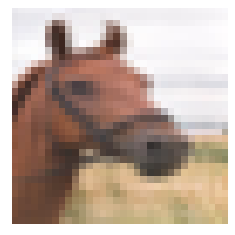

In [ ]:
image_id = 99 # Index des Bildes aus Testset das geladen werden soll (gerne ändern um euch ander Bilder anzusehen)
helper.plot_image(x_test[image_id])

## Image Perturbation

Als allererstes brauchen wir eine Funktion die in der Lage ist ein oder mehrere Pixel in einem Bild zu verändern.

Dabei kann Jedes Pixel als 5-tupel definiert werden.

$$\textbf{x} = (x, y, r, g, b)$$

Dabei sind $x$ und $y$ die Kooridinaten des Pixels im Bild (jeweils von 0 bis 31).

$r,g,b$ gibt die Rot, Grün, Blau Werte des Pixels an (jeweils von 0 bis 255).

Mehrere dieser Veränderungen können dann wie folgt dargestellt werden:

$$X = (x_1, y_1, r_1, g_1, b_1, x_2, y_2, r_2, g_2, b_2, ...)$$

Grund für diese Wahl der Konkatenation ist, dass der Optimierungsalgorithmus der später vorgestellt wird einen eindimensionalen Vektor als Eingabe benötigt.

Zumsammengefasst bedeutet das, das die Funktion ein Bild sowie den Veränderungsvektor $X$ als Eingabe erhält und als Ausgabe ein Bild produziert welches die selben Dimensionen wie $X$ hat aber ein verändertes Pixel an der Stelle $x_i,y_i$ mit den neuen Farbwerten $r_i,g_i,b_i$ aufweist.

Um diesen Prozess zu beschleunigen werden mehrere dieser Veränderungen zusammengefasst zu $X_S$.


In [ ]:
def perturb_image(xs, img):
    # wenn nur ein Vektor gegeben wird,
    # wird dieser trotzdem in ein Array der Länge 1 gepackt,
    # damit die Berechnung gleich bleibt
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # das Bild wird nun so oft kopiert wie es Veränderungen gibt (n==len(xs))
    # um die selbe Anzahl an veränderten Bildern zu erhalten (n veränderte Bilder)
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    # Sichert zu das Inhalt von xs nur aus Integer Werten besteht
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # nun wird der Veränderungsvektor in seine einzelnen 5-Tupel Bestandteile zerlegt
        # z.b. [[x,y,r,g,b],[x2,y2,r2,g2,b2], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # nun wird dem Pixel sein neuer RGB Wert zugewiesen
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs

Jetzt sind wir in der Lage jedes Pixel eines Bildes zu verändern wie wir wollen.

Hier das Beispiel Bild mtit einem veränderten Pixel.
Dabei wird das Pixel an der Stelle (16,16) auf die Farbe Gelb gesetzt.

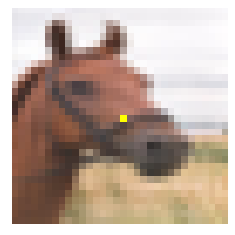

In [ ]:
image_id = 99 # Index des Bildes aus Testset das geladen werden soll
pixel = np.array([16, 16, 255, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, x_test[image_id])[0]

helper.plot_image(image_perturbed)

## Laden von Vortrainierten KI Modellen

Um übehaupt einen Angriff auszuführen, brauchen wir erst ein KI Netzwerk.
Dieses ist hier bereits auf das Cifar10 Dataset trainiert.

Hier sind 2 Netzwerke enthalten, LeNet und ResNet.
Diese sind recht simple, für Demonstrationszwecke aber ausreichend.

Die Funktionsweise ist bei komplexeren Netzwerken identisch, allerdings wird deutlich mehr Zeit und Rechenleistung benötigt um ein Bild erfolgreich zu manipulieren.

In [ ]:
lenet = LeNet()
resnet = ResNet()

models = [lenet, resnet]

Successfully loaded lenet
Successfully loaded resnet


### Berechnung der Genauigkeit der Modelle

Nach dem Laden können wir nun Validieren wie gut diese Netzwerke Bilder aus dem Cifar10 Dataset klassifieren können.

Damit wir korrekt ermitteln können ob ein Angriff erfolgreich war, ist es nötig das nur Bilder verwendet werden die korrekt erkannt wurden.

Dies wird in der folgenden Zelle gemacht. Ebenso wird die Genauigkeit der beiden Netzwerke sowie die Menge an Parameter angegeben die das Netzwerk definieren.

In [ ]:
network_stats, correct_imgs = helper.evaluate_models(models, x_test, y_test)
correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy', 'param_count'])

network_stats

Evaluating lenet
79/79 [==============================] - 8s 3ms/step
Evaluating resnet
79/79 [==============================] - 2s 12ms/step


,name,accuracy,param_count
0,lenet,0.7488,62006
1,resnet,0.9231,470218


### Vorhersage Funktionalität

Da wir von einem Black-Box Angriff ausgehen, sind für uns nur die Inputs und Outputs eines Netzwerks von Bedeutung.
Bei den Outputs sind hier vorallem die Vorhersagen Wahrscheinlichkeiten (prediction Probabilities) wichtig.

Diese geben an wie wahrscheinlich unterschiedliche Klassen, nach wissen des Netzwerkes, sind.

Sinn der Sache ist, das wir einfach das Netzwerk austauschen können, ohne das wir dadurch unser Vorgehen ändern müssen.

Diese Funktion verwendet nun die ``predict`` Funktion eines Keras KI-Modells.
In dieser werden nun die Prediction Probalility einer Zielklasse ``target_class`` des Bildes ermittelt. Dieser werd wird auch als Confidence bezeichnet.

Ist``target_class`` das korrekte Label, so ist unser Ziel die Confidence des Netzwerkes so weit zu senken, das ein anderes Label als das korrekte erkannt wird.

Ist ``target_class`` stattdesen die Klasse, welche an Stelle der korrekten Klasse erkannt werden soll, so wollen wir die Confidence des Netzwerkes erhöhen.
Da wir aber die selbe Optimerung für beide Szenarien verwenden, wird in diesem Fall ``1-predictions`` zurückgegeben.

Ziel des ganzen ist es in beiden Fällen die Rückgabe dieser Funktion zu minimieren, um eine optimale Lösung (optimale Farbe und Position des veränderten Pixels) zu finden.

In [ ]:
def predict_classes(xs, img, target_class, model, minimize=True):
    # Verändern des Bildes mithilfe des Veränderungsvektor xs
    imgs_perturbed = perturb_image(xs, img)
    # Confidence des Netzwerkes ermittelt, mit welcher das veränderte Bild teil der Zielklasse ist
    predictions = model.predict(imgs_perturbed)[:,target_class]
    # Diese Funktion wird immer minimiert, deshalb wird falls nötig das Komplement der Confidence zurückgegeben
    return predictions if minimize else 1 - predictions

Unten wird dieses Verhalten expemplarisch demonstiert.
Es wird ein Bild sowie seine Pertubation erstellt und getestet.

Es ist zu sehen das die Confidence des Netzwerkes, das dieses Bild einen Vogel zeigt, von ca. 70% auf den Bruchteil eines Prozents gesunken ist.

Dies ist ein Beispiel, indem sowohl die Position als auch die Farbe des Pixels bereits optimiert wurden.
Ein solches Verhalten ist durch zufällige Auswahl eines Pixels und dessen Farbe nicht zu erwarten.

1/1 [==============================] - 0s 17ms/step
Confidence in true class bird is 0.000188873
Prior confidence was 0.70661765


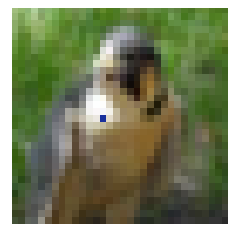

In [ ]:
image_id = 384
pixel = np.array([16, 13,  25, 48, 156])
model = resnet

true_class = y_test[image_id, 0]
prior_confidence = model.predict_one(x_test[image_id])[true_class]
confidence = predict_classes(pixel, x_test[image_id], true_class, model)[0]

print('Confidence in true class', class_names[true_class], 'is', confidence)
print('Prior confidence was', prior_confidence)
helper.plot_image(perturb_image(pixel, x_test[image_id])[0])

## Der Angriff

Here we will demonstrate two variants of the one pixel attack: untargeted and targeted.

### Targeted vs. Untargeted Attacks

The objective of an untargeted attack is to cause a model to misclassify an image. This means we want to perturb an image as to minimize the confidence probability of the correct classification category and maximize the sum of the probabilities of all other categories.

The objective of a targeted attack is to cause a model to classify an image as a given  target class. We want to perturb an image as to maximize the probability of a class of our own choosing.

### Success Criterion

Define a function so that whenever a given perturbation is sufficient to fool a model, it returns `True`. This will be called the success criterion. The `targeted_attack` boolean flag will indicate whether success means maximization of the target class or minimization of the correct (target) class.

In [ ]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = perturb_image(x, img)

    confidence = model.predict(attack_image)[0]
    predicted_class = np.argmax(confidence)
    
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True
    if verbose:
        print('Confidence:', confidence[target_class])
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True
    # NOTE: return None otherwise (not False), due to how Scipy handles its callback function

Here we demonstrate the usage of the success criterion function. It's nearly identical to `predict_class()` as before, but also decides the success of the attack. For purposes of demonstration we assume an untargeted attack.

1/1 [==============================] - 0s 20ms/step
Confidence: 0.074600935
Prior confidence 0.50054055
Attack success: True


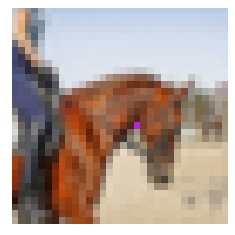

In [ ]:
image_id = 541
pixel = np.array([17, 18, 185, 36, 215])
model = resnet

true_class = y_test[image_id, 0]
prior_confidence = model.predict_one(x_test[image_id])[true_class]
success = attack_success(pixel, x_test[image_id], true_class, model, verbose=True)

print('Prior confidence', prior_confidence)
print('Attack success:', success == True)
helper.plot_image(perturb_image(pixel, x_test[image_id])[0])

### Attack Function

Finally, we arrive at the attack itself: how do we find the pixels that will result in a successful attack? First, formulate it as an optimization problem: in an untargeted attack, minimize the confidence of the correct class, and in a targeted attack, maximize the confidence of a target class. This is precisely our `predict_class` function.

When performing black-box optimizations such as the one pixel attack, it can be very difficult to find an efficient gradient-based optimization that will work for the problem. It would be nice to use an optimization algorithm that can find good solutions without relying on the smoothness of the function. In our case, we have discrete integer positions ranging from 0 to 31 and color intensities from 0 to 255, so the function is expected to be jagged.

For that, we use an algorithm called [differential evolution](https://en.wikipedia.org/wiki/Differential_evolution). Here's an example of differential evolution optimizing the [Ackley function](https://en.wikipedia.org/wiki/Ackley_function) (if you're using Google Colab, run the code cell below):

<br>

![Ackley GIF](https://github.com/hyperparticle/one-pixel-attack-keras/blob/master/images/Ackley.gif?raw=1)

<br>

Differential evolution is a type of evolutionary algorithm where a population of candidate solutions generate offspring which compete with the rest of the population each generation according to their fitness. Each candidate solution is represented by a vector of real numbers which are the inputs to the function we would like to minimize. The lower the output of this function, the better the fitness. The algorithm works by initializing a (usually random) population of vectors, generating new offspring vectors by combining (mutating) individuals in the population, and replacing worse-performing individuals with better candidates.

In the context of the one pixel attack, our input will be a flat vector of pixel values:

$$X = (x_1, y_1, r_1, g_1, b_1, x_2, y_2, r_2, g_2, b_2, ...)$$

These will be encoded as floating-point values, but will be floored back into integers to calculate image perturbations. First we generate a random population of $n$ perturbations

$$\textbf{P} = (X_1, X_2, \dots, X_n)$$

Then, on each iteration we calculate $n$ new mutant children using the formula

$$X_i = X_{r1} + F (X_{r2} - X_{r3})$$

such that

$$r1 \neq r2 \neq r3$$

where $r1,r2,r3$ are random indices into our population $\textbf{P}$, and $F = 0.5$ is a mutation parameter. Basically, we pick 3 random individuals from the previous generation and recombine them to make a new candidate solution. If this candidate $X_i$ gives a lower minimum at position $i$ (i.e., the attack is closer to success), replace the old $X_i$ with this new one. This process repeats for several iterations until our stopping criterion, `attack_success`, which is when we find an image that successfully completes the attack.

<br>

See [this excellent tutorial post](https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/) on how differential evolution works in greater detail. 

We will use a [slight modification](differential_evolution.py) of [Scipy's implementation of differential evolution](https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.differential_evolution.html) to utilize GPU parallelism by batching predictions together.

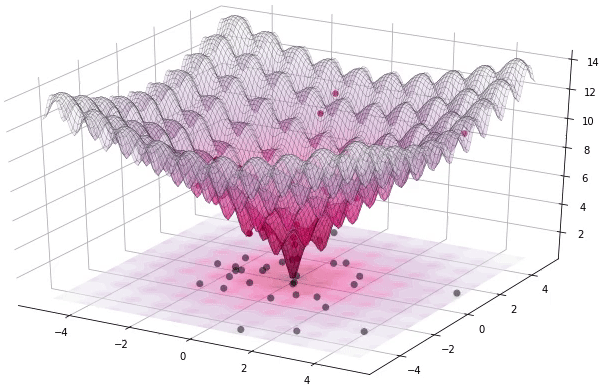

In [ ]:
# Run this cell if you are using Google Colab to see the Ackley GIF
if in_colab:
    from IPython.display import Image
    with open('images/Ackley.gif','rb') as file:
        display(Image(file.read()))

In [ ]:
def attack(img_id, model, target=None, pixel_count=1, 
           maxiter=75, popsize=400, verbose=False):
    # Change the target class based on whether this is a targeted attack or not
    targeted_attack = target is not None
    target_class = target if targeted_attack else y_test[img_id, 0]
    
    # Define bounds for a flat vector of x,y,r,g,b values
    # For more pixels, repeat this layout
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return predict_classes(xs, x_test[img_id], target_class, 
                               model, target is None)
    
    def callback_fn(x, convergence):
        return attack_success(x, x_test[img_id], target_class, 
                              model, targeted_attack, verbose)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)

    # Calculate some useful statistics to return from this function
    attack_image = perturb_image(attack_result.x, x_test[img_id])[0]
    prior_probs = model.predict_one(x_test[img_id])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img_id, 0]
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    # Show the best attempt at a solution (successful or not)
    helper.plot_image(attack_image, actual_class, class_names, predicted_class)

    return [model.name, pixel_count, img_id, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_result.x]

#### Untargeted Attack

Let's look at one iteration of the untargeted attack. Here we will demonstrate a successful attack an image of a frog with the `resnet` model. We should see the confidence in the true class drop after several iterations.

Try to see if you can successfully attack other images/models. The more pixels we are allowed to modify, the more likely it is we are to find a solution for any given image.

1/1 [==============================] - 0s 17ms/step
Confidence: 0.79889685
1/1 [==============================] - 0s 17ms/step
Confidence: 0.660813
1/1 [==============================] - 0s 17ms/step
Confidence: 0.660813
1/1 [==============================] - 0s 18ms/step
Confidence: 0.660813
1/1 [==============================] - 0s 17ms/step
Confidence: 0.660813
1/1 [==============================] - 0s 17ms/step
Confidence: 0.660813
1/1 [==============================] - 0s 17ms/step
Confidence: 0.660813
1/1 [==============================] - 0s 17ms/step
Confidence: 0.660813
1/1 [==============================] - 0s 16ms/step
Confidence: 0.49269065
1/1 [==============================] - 0s 16ms/step


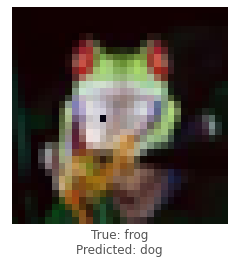

In [ ]:
image_id = 102
pixels = 1 # Number of pixels to attack
model = resnet

_ = attack(image_id, model, pixel_count=pixels, verbose=True)

#### Targeted Attack

In the targeted attack, we can choose which class we want a model to classify an image as. The task is much harder for the targeted attack, as we constrain the misclassification to a given class rather than any class that's not the correct one. We should see the confidence in the target class rise after several iterations.

Below we try to cause the `lenet` to classify an image of a `ship` as an `automobile`. Try to change the parameters and see what happens.

Attacking with target automobile
1/1 [==============================] - 0s 43ms/step
Confidence: 0.0428564
1/1 [==============================] - 0s 17ms/step
Confidence: 0.0428564
1/1 [==============================] - 0s 19ms/step
Confidence: 0.0428564
1/1 [==============================] - 0s 15ms/step
Confidence: 0.0428564
1/1 [==============================] - 0s 16ms/step
Confidence: 0.044170912
1/1 [==============================] - 0s 20ms/step
Confidence: 0.06923807
1/1 [==============================] - 0s 17ms/step
Confidence: 0.07217568
1/1 [==============================] - 0s 16ms/step
Confidence: 0.07217568
1/1 [==============================] - 0s 15ms/step
Confidence: 0.07217568
1/1 [==============================] - 0s 15ms/step
Confidence: 0.07217568
1/1 [==============================] - 0s 14ms/step
Confidence: 0.2511525
1/1 [==============================] - 0s 17ms/step
Confidence: 0.2511525
1/1 [==============================] - 0s 14ms/step
Confidence: 0.251152

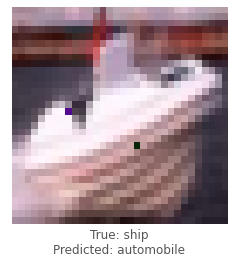

In [ ]:
image_id = 108
target_class = 1 # Integer in range 0-9
pixels = 3
model = lenet

print('Attacking with target', class_names[target_class])
_ = attack(image_id, model, target_class, pixel_count=pixels, verbose=True)

### Collect Results

Armed with all the necessary tools to conduct a one pixel attack, the final step is to collect relevant statistics on the targeted and untargeted attack. The relevant data points are what percentage of images were we able to successfully attack for a given model, and how the number of pixels affect this percentage.

We will loop through every combination of all models, perturbations of 1,3,5 pixels, images, and target classes (for the targeted attack). This will take a lot of computational resources and time, so [skip to the statistics section](#Attack-Statistics) if that's not your idea of fun.

In [ ]:
def attack_all(models, samples=500, pixels=(1,3,5), targeted=False, 
               maxiter=75, popsize=400, verbose=False):
    results = []
    for model in models:
        model_results = []
        valid_imgs = correct_imgs[correct_imgs.name == model.name].img
        img_samples = np.random.choice(valid_imgs, samples, replace=False)
        
        for pixel_count in pixels:
            for i, img_id in enumerate(img_samples):
                print('\n', model.name, '- image', img_id, '-', i+1, '/', len(img_samples))
                targets = [None] if not targeted else range(10)
                
                for target in targets:
                    if targeted:
                        print('Attacking with target', class_names[target])
                        if target == y_test[img_id, 0]:
                            continue
                    result = attack(img_id, model, target, pixel_count, 
                                    maxiter=maxiter, popsize=popsize, 
                                    verbose=verbose)
                    model_results.append(result)
                    
        results += model_results
        helper.checkpoint(results, targeted)
    return results


 lenet - image 2621 - 1 / 10
1/1 [==============================] - 0s 16ms/step


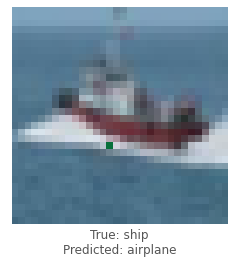


 lenet - image 1295 - 2 / 10
1/1 [==============================] - 0s 13ms/step


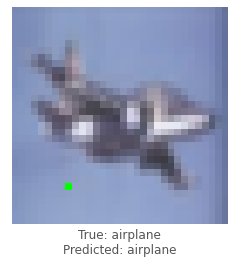


 lenet - image 5744 - 3 / 10
1/1 [==============================] - 0s 15ms/step


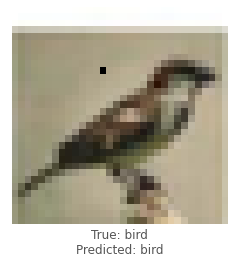


 lenet - image 413 - 4 / 10
1/1 [==============================] - 0s 16ms/step


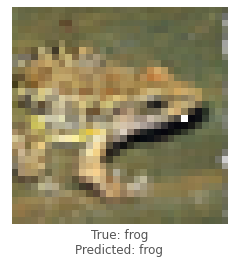


 lenet - image 4272 - 5 / 10
1/1 [==============================] - 0s 14ms/step


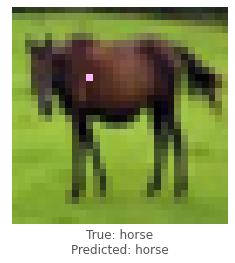


 lenet - image 6611 - 6 / 10
1/1 [==============================] - 0s 17ms/step


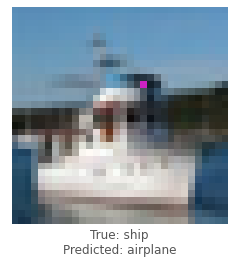


 lenet - image 9413 - 7 / 10
1/1 [==============================] - 0s 15ms/step


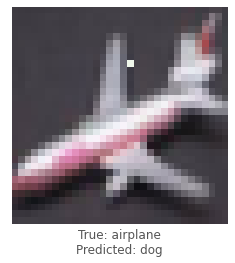


 lenet - image 3286 - 8 / 10
1/1 [==============================] - 0s 14ms/step


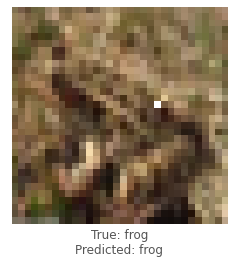


 lenet - image 344 - 9 / 10
1/1 [==============================] - 0s 14ms/step


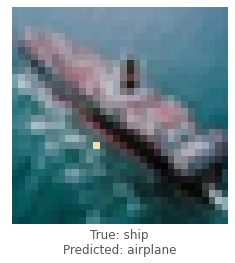


 lenet - image 167 - 10 / 10
1/1 [==============================] - 0s 18ms/step


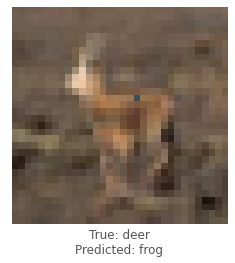


 resnet - image 964 - 1 / 10
1/1 [==============================] - 0s 17ms/step


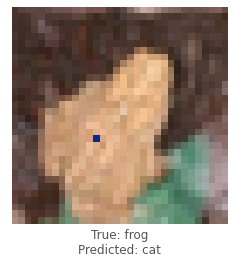


 resnet - image 1168 - 2 / 10
1/1 [==============================] - 0s 19ms/step


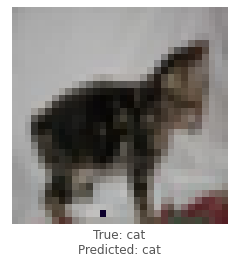


 resnet - image 8881 - 3 / 10
1/1 [==============================] - 0s 16ms/step


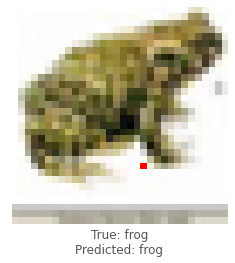


 resnet - image 8857 - 4 / 10
1/1 [==============================] - 0s 18ms/step


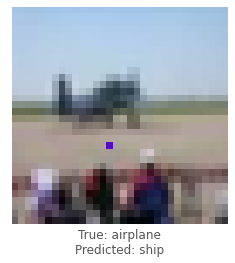


 resnet - image 7666 - 5 / 10
1/1 [==============================] - 0s 32ms/step


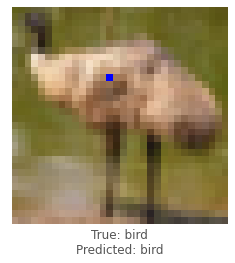


 resnet - image 1783 - 6 / 10
1/1 [==============================] - 0s 19ms/step


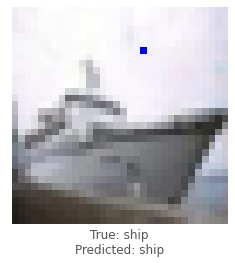


 resnet - image 233 - 7 / 10
1/1 [==============================] - 0s 15ms/step


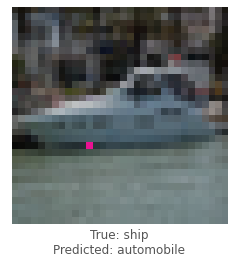


 resnet - image 5841 - 8 / 10
1/1 [==============================] - 0s 18ms/step


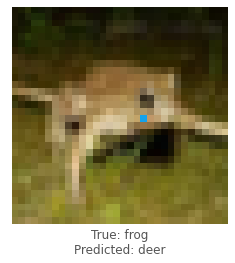


 resnet - image 6914 - 9 / 10
1/1 [==============================] - 0s 16ms/step


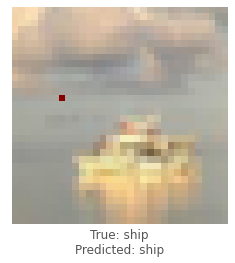


 resnet - image 2460 - 10 / 10
1/1 [==============================] - 0s 18ms/step


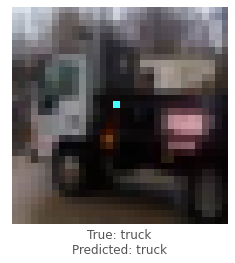

In [ ]:
untargeted = attack_all(models, samples=10, targeted=False, pixels=(1,))


 lenet - image 2341 - 1 / 10
Attacking with target airplane
Attacking with target automobile
1/1 [==============================] - 0s 15ms/step


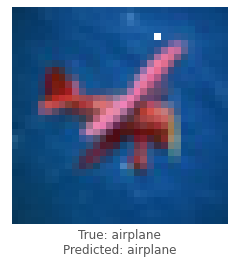

Attacking with target bird
1/1 [==============================] - 0s 15ms/step


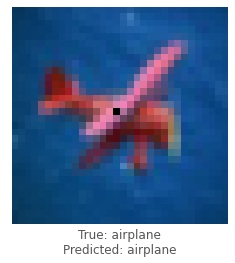

Attacking with target cat
1/1 [==============================] - 0s 17ms/step


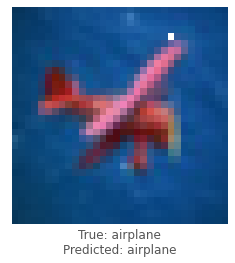

Attacking with target deer
1/1 [==============================] - 0s 13ms/step


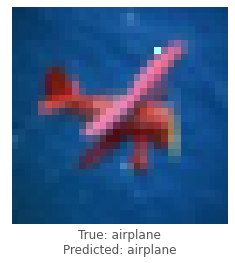

Attacking with target dog
1/1 [==============================] - 0s 15ms/step


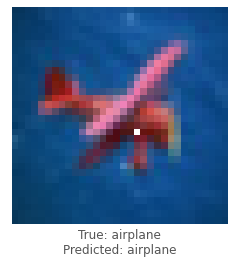

Attacking with target frog
1/1 [==============================] - 0s 14ms/step


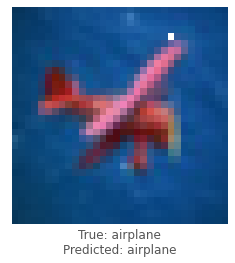

Attacking with target horse
1/1 [==============================] - 0s 13ms/step


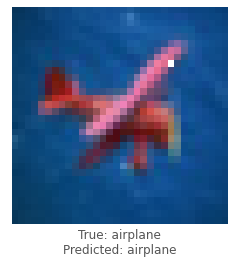

Attacking with target ship
1/1 [==============================] - 0s 16ms/step


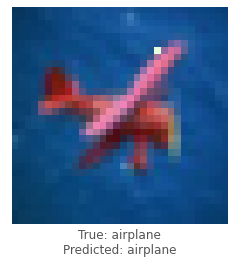

Attacking with target truck
1/1 [==============================] - 0s 16ms/step


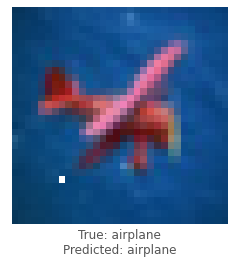


 lenet - image 1353 - 2 / 10
Attacking with target airplane
1/1 [==============================] - 0s 17ms/step


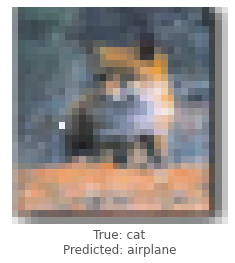

Attacking with target automobile
1/1 [==============================] - 0s 14ms/step


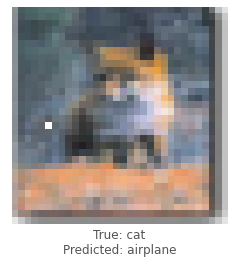

Attacking with target bird
1/1 [==============================] - 0s 13ms/step


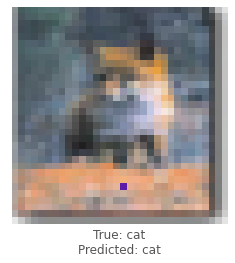

Attacking with target cat
Attacking with target deer
1/1 [==============================] - 0s 15ms/step


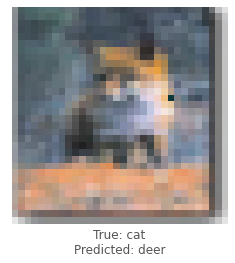

Attacking with target dog
1/1 [==============================] - 0s 14ms/step


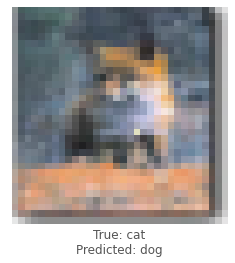

Attacking with target frog
1/1 [==============================] - 0s 19ms/step


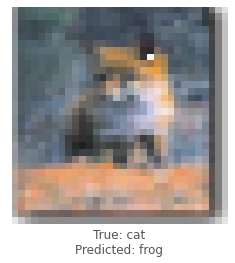

Attacking with target horse
1/1 [==============================] - 0s 15ms/step


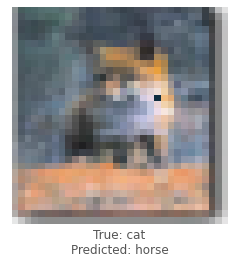

Attacking with target ship
1/1 [==============================] - 0s 14ms/step


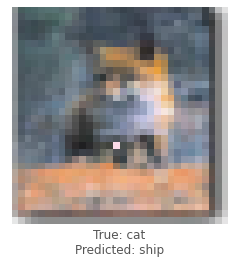

Attacking with target truck
1/1 [==============================] - 0s 19ms/step


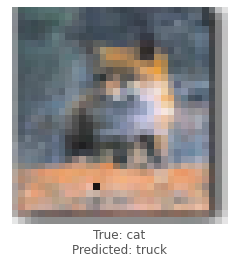


 lenet - image 281 - 3 / 10
Attacking with target airplane
Attacking with target automobile
1/1 [==============================] - 0s 17ms/step


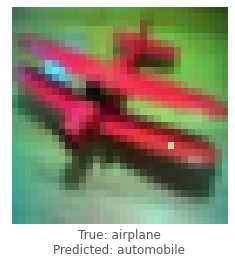

Attacking with target bird
1/1 [==============================] - 0s 18ms/step


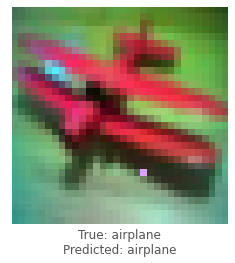

Attacking with target cat
1/1 [==============================] - 0s 13ms/step


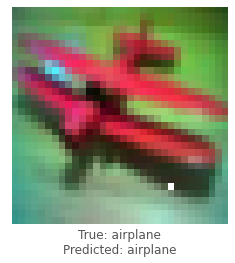

Attacking with target deer
1/1 [==============================] - 0s 15ms/step


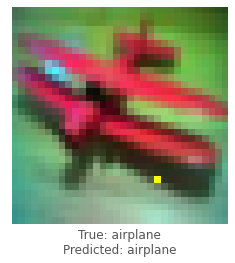

Attacking with target dog
1/1 [==============================] - 0s 14ms/step


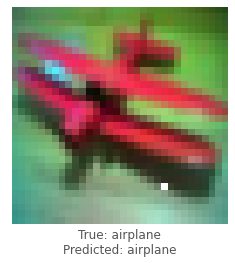

Attacking with target frog
1/1 [==============================] - 0s 15ms/step


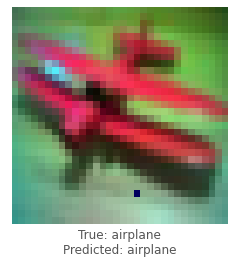

Attacking with target horse
1/1 [==============================] - 0s 13ms/step


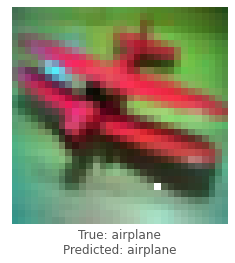

Attacking with target ship
1/1 [==============================] - 0s 16ms/step


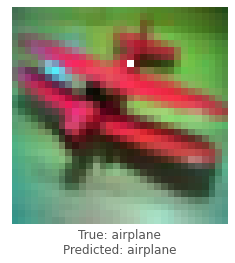

Attacking with target truck
1/1 [==============================] - 0s 15ms/step


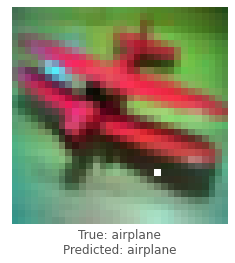


 lenet - image 8208 - 4 / 10
Attacking with target airplane
1/1 [==============================] - 0s 17ms/step


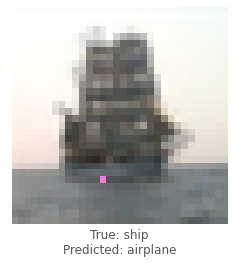

Attacking with target automobile
1/1 [==============================] - 0s 15ms/step


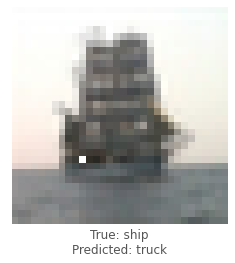

Attacking with target bird
1/1 [==============================] - 0s 13ms/step


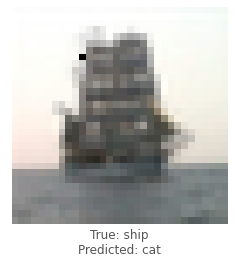

Attacking with target cat
1/1 [==============================] - 0s 14ms/step


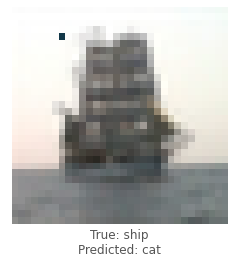

Attacking with target deer
1/1 [==============================] - 0s 14ms/step


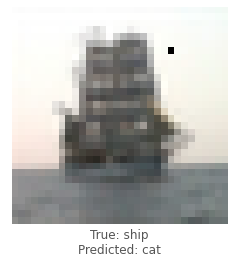

Attacking with target dog
1/1 [==============================] - 0s 13ms/step


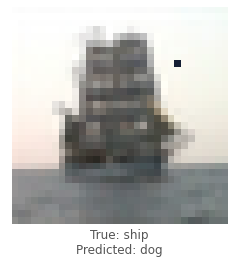

Attacking with target frog
1/1 [==============================] - 0s 13ms/step


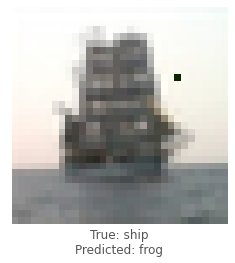

Attacking with target horse
1/1 [==============================] - 0s 19ms/step


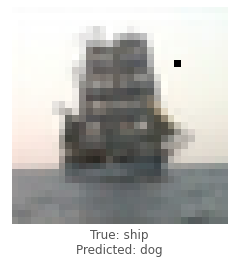

Attacking with target ship
Attacking with target truck
1/1 [==============================] - 0s 16ms/step


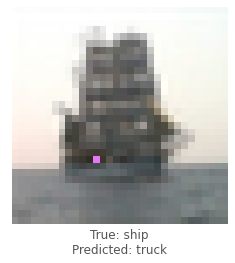


 lenet - image 3268 - 5 / 10
Attacking with target airplane
4/4 [==============================] - 0s 4ms/step


/content/differential_evolution.py:585: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


1/1 [==============================] - 0s 15ms/step


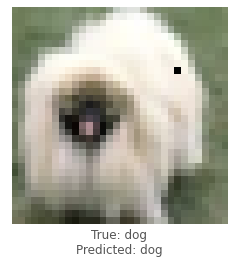

Attacking with target automobile
1/1 [==============================] - 0s 15ms/step


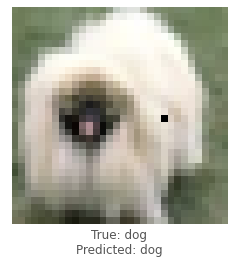

Attacking with target bird
1/1 [==============================] - 0s 13ms/step


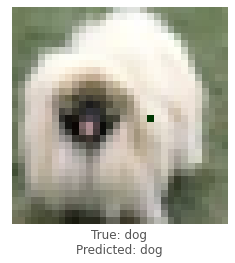

Attacking with target cat
1/1 [==============================] - 0s 13ms/step


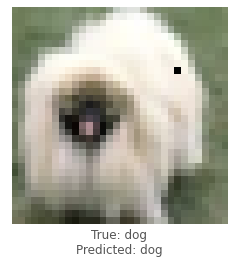

Attacking with target deer
1/1 [==============================] - 0s 13ms/step


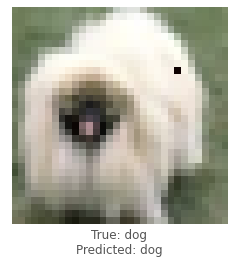

Attacking with target dog
Attacking with target frog
1/1 [==============================] - 0s 17ms/step


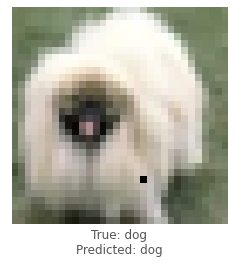

Attacking with target horse
1/1 [==============================] - 0s 15ms/step


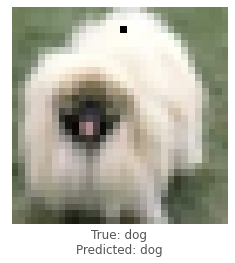

Attacking with target ship
1/1 [==============================] - 0s 14ms/step


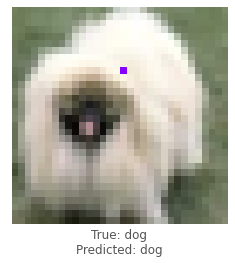

Attacking with target truck
1/1 [==============================] - 0s 15ms/step


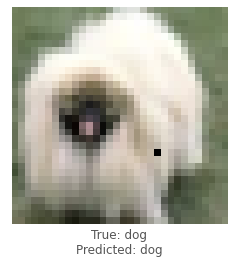


 lenet - image 4269 - 6 / 10
Attacking with target airplane
Attacking with target automobile
1/1 [==============================] - 0s 15ms/step


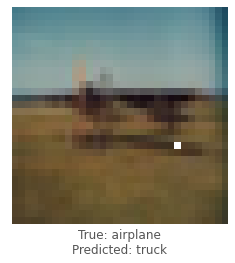

Attacking with target bird
1/1 [==============================] - 0s 13ms/step


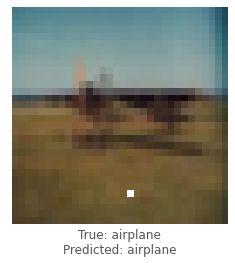

Attacking with target cat
1/1 [==============================] - 0s 13ms/step


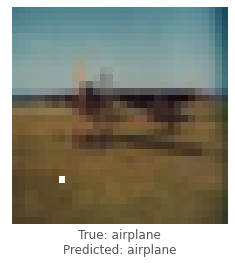

Attacking with target deer
1/1 [==============================] - 0s 15ms/step


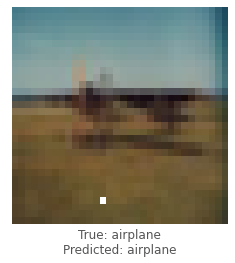

Attacking with target dog
1/1 [==============================] - 0s 16ms/step


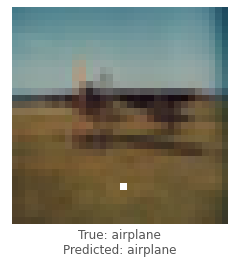

Attacking with target frog
1/1 [==============================] - 0s 15ms/step


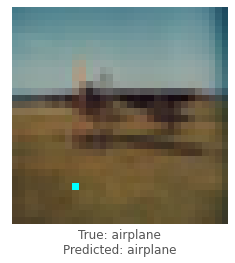

Attacking with target horse
1/1 [==============================] - 0s 15ms/step


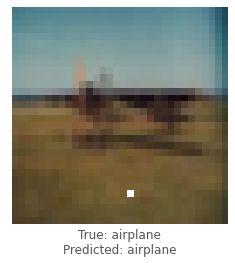

Attacking with target ship
1/1 [==============================] - 0s 13ms/step


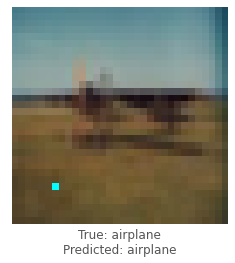

Attacking with target truck
1/1 [==============================] - 0s 16ms/step


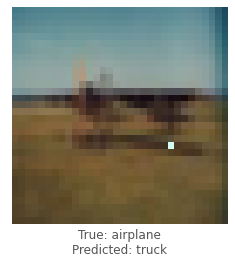


 lenet - image 1844 - 7 / 10
Attacking with target airplane
1/1 [==============================] - 0s 21ms/step


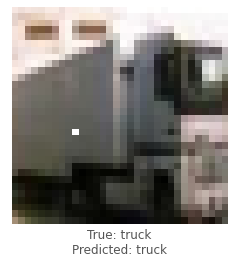

Attacking with target automobile
1/1 [==============================] - 0s 14ms/step


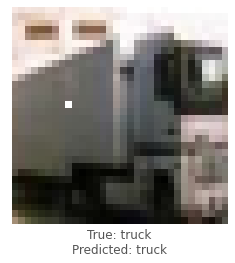

Attacking with target bird
1/1 [==============================] - 0s 16ms/step


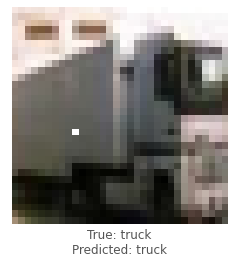

Attacking with target cat
1/1 [==============================] - 0s 17ms/step


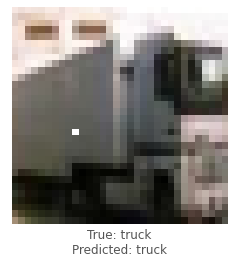

Attacking with target deer
1/1 [==============================] - 0s 15ms/step


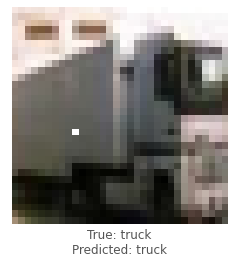

Attacking with target dog
1/1 [==============================] - 0s 15ms/step


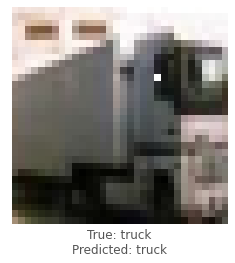

Attacking with target frog
1/1 [==============================] - 0s 22ms/step


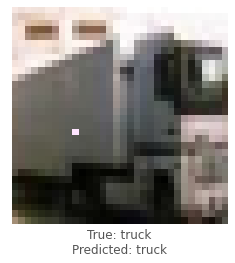

Attacking with target horse
1/1 [==============================] - 0s 15ms/step


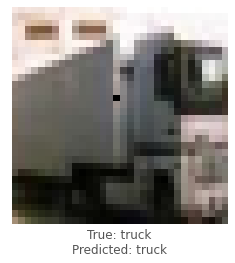

Attacking with target ship
1/1 [==============================] - 0s 21ms/step


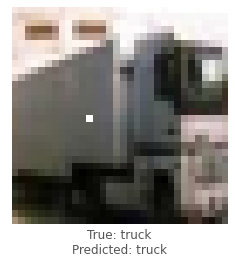

Attacking with target truck

 lenet - image 623 - 8 / 10
Attacking with target airplane
1/1 [==============================] - 0s 14ms/step


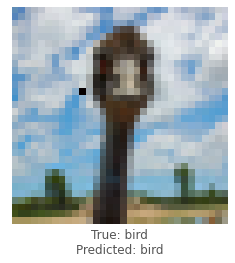

Attacking with target automobile
1/1 [==============================] - 0s 14ms/step


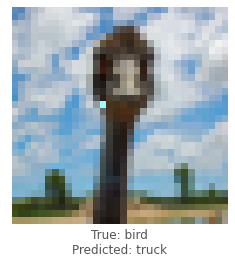

Attacking with target bird
Attacking with target cat
1/1 [==============================] - 0s 14ms/step


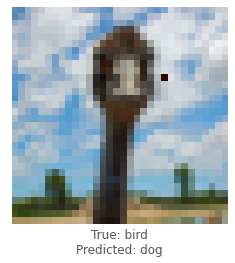

Attacking with target deer
1/1 [==============================] - 0s 17ms/step


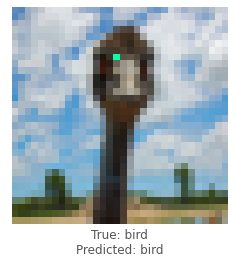

Attacking with target dog
1/1 [==============================] - 0s 17ms/step


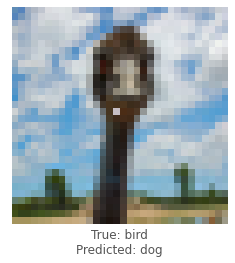

Attacking with target frog
1/1 [==============================] - 0s 16ms/step


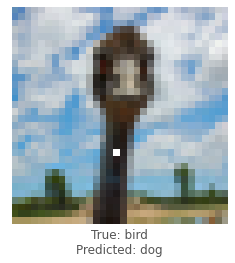

Attacking with target horse
1/1 [==============================] - 0s 16ms/step


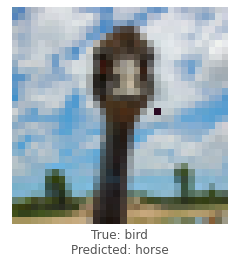

Attacking with target ship
1/1 [==============================] - 0s 15ms/step


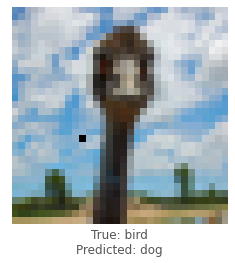

Attacking with target truck
1/1 [==============================] - 0s 16ms/step


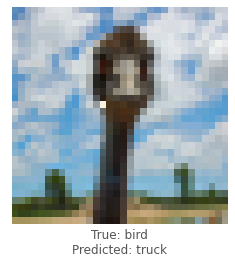


 lenet - image 3585 - 9 / 10
Attacking with target airplane
1/1 [==============================] - 0s 24ms/step


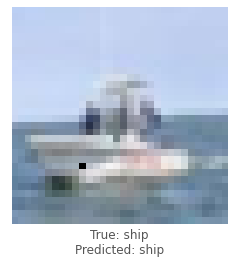

Attacking with target automobile
1/1 [==============================] - 0s 14ms/step


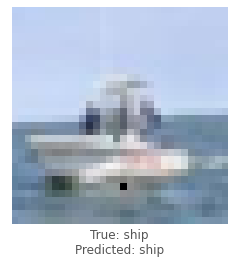

Attacking with target bird
1/1 [==============================] - 0s 15ms/step


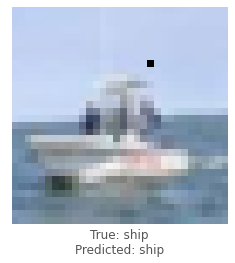

Attacking with target cat
1/1 [==============================] - 0s 14ms/step


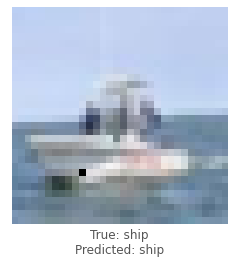

Attacking with target deer
1/1 [==============================] - 0s 18ms/step


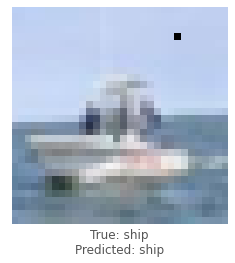

Attacking with target dog
1/1 [==============================] - 0s 20ms/step


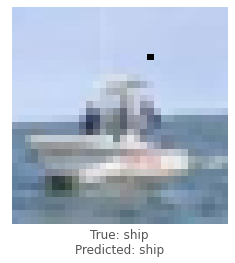

Attacking with target frog
1/1 [==============================] - 0s 18ms/step


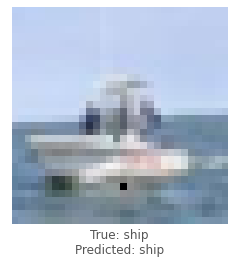

Attacking with target horse
1/1 [==============================] - 0s 17ms/step


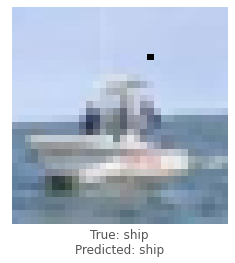

Attacking with target ship
Attacking with target truck
1/1 [==============================] - 0s 14ms/step


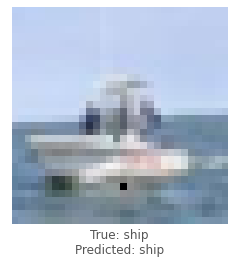


 lenet - image 7640 - 10 / 10
Attacking with target airplane
1/1 [==============================] - 0s 20ms/step


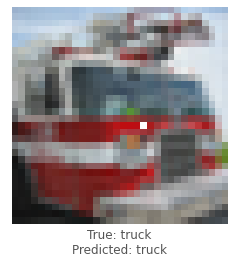

Attacking with target automobile
1/1 [==============================] - 0s 18ms/step


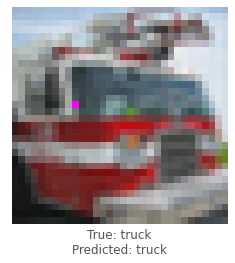

Attacking with target bird
1/1 [==============================] - 0s 15ms/step


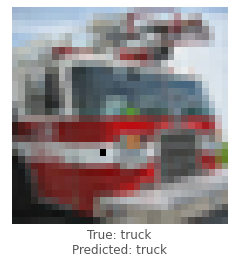

Attacking with target cat
1/1 [==============================] - 0s 23ms/step


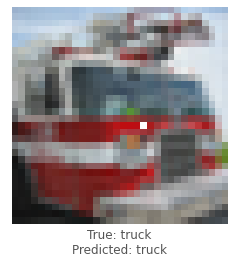

Attacking with target deer
1/1 [==============================] - 0s 21ms/step


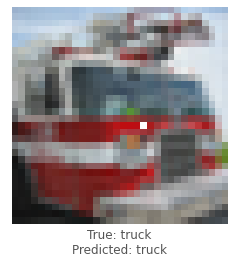

Attacking with target dog
1/1 [==============================] - 0s 15ms/step


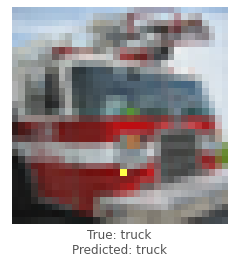

Attacking with target frog
1/1 [==============================] - 0s 18ms/step


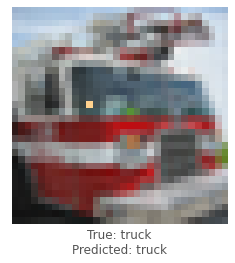

Attacking with target horse
1/1 [==============================] - 0s 26ms/step


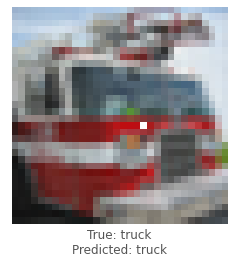

Attacking with target ship
1/1 [==============================] - 0s 17ms/step


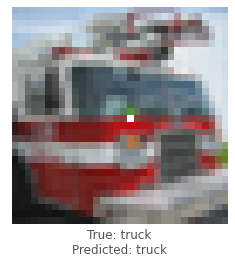

Attacking with target truck

 resnet - image 9924 - 1 / 10
Attacking with target airplane
1/1 [==============================] - 0s 18ms/step


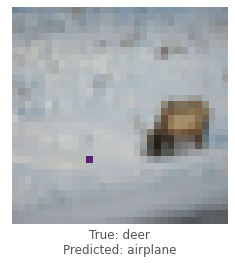

Attacking with target automobile
1/1 [==============================] - 0s 28ms/step


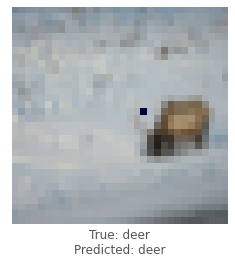

Attacking with target bird
1/1 [==============================] - 0s 17ms/step


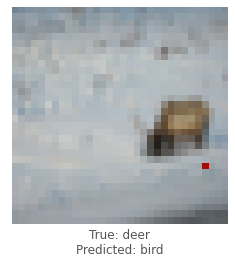

Attacking with target cat
1/1 [==============================] - 0s 17ms/step


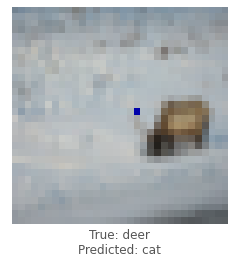

Attacking with target deer
Attacking with target dog
1/1 [==============================] - 0s 21ms/step


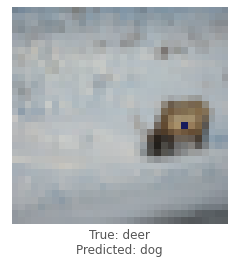

Attacking with target frog
1/1 [==============================] - 0s 21ms/step


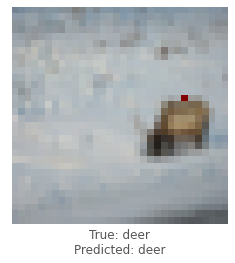

Attacking with target horse
1/1 [==============================] - 0s 18ms/step


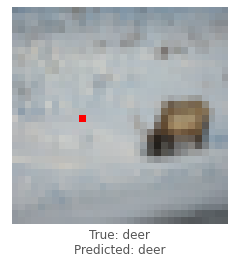

Attacking with target ship
1/1 [==============================] - 0s 19ms/step


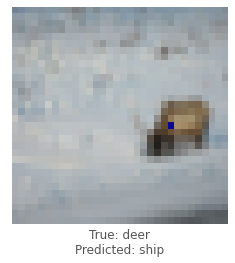

Attacking with target truck
1/1 [==============================] - 0s 17ms/step


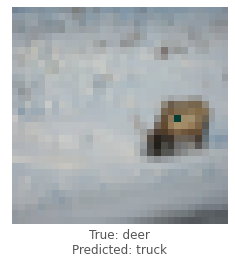


 resnet - image 2038 - 2 / 10
Attacking with target airplane
1/1 [==============================] - 0s 20ms/step


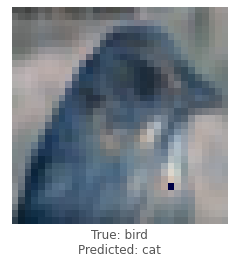

Attacking with target automobile
1/1 [==============================] - 0s 17ms/step


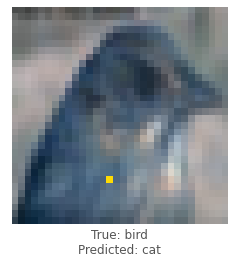

Attacking with target bird
Attacking with target cat
1/1 [==============================] - 0s 17ms/step


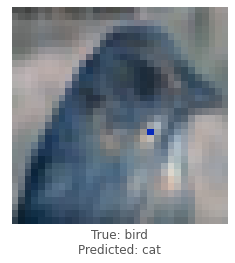

Attacking with target deer
1/1 [==============================] - 0s 24ms/step


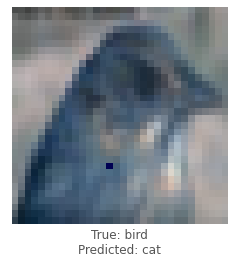

Attacking with target dog
1/1 [==============================] - 0s 19ms/step


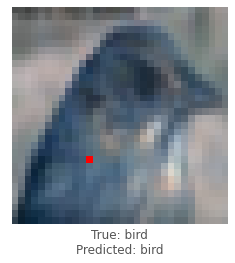

Attacking with target frog
1/1 [==============================] - 0s 22ms/step


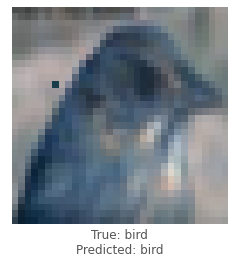

Attacking with target horse
1/1 [==============================] - 0s 30ms/step


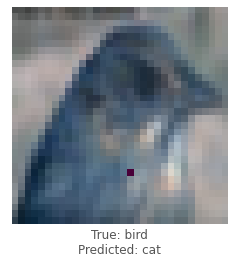

Attacking with target ship
1/1 [==============================] - 0s 27ms/step


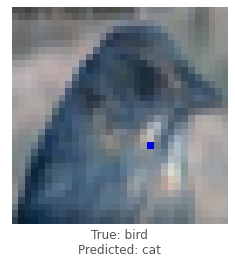

Attacking with target truck
1/1 [==============================] - 0s 21ms/step


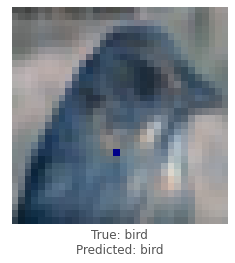


 resnet - image 1307 - 3 / 10
Attacking with target airplane
1/1 [==============================] - 0s 21ms/step


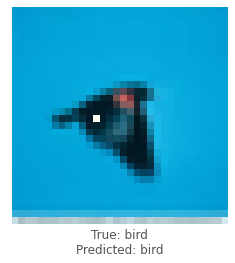

Attacking with target automobile
1/1 [==============================] - 0s 34ms/step


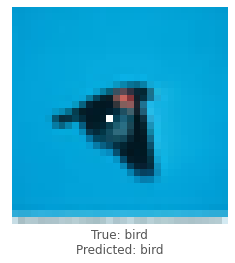

Attacking with target bird
Attacking with target cat
1/1 [==============================] - 0s 20ms/step


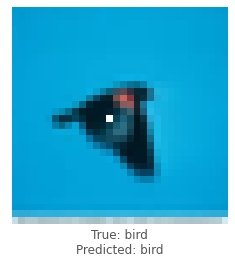

Attacking with target deer
1/1 [==============================] - 0s 20ms/step


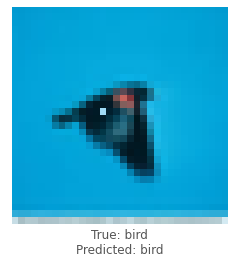

Attacking with target dog
1/1 [==============================] - 0s 27ms/step


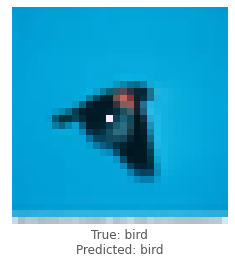

Attacking with target frog
1/1 [==============================] - 0s 23ms/step


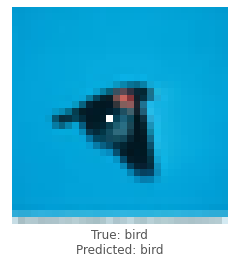

Attacking with target horse
1/1 [==============================] - 0s 23ms/step


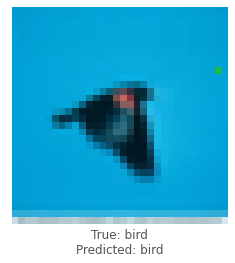

Attacking with target ship
1/1 [==============================] - 0s 20ms/step


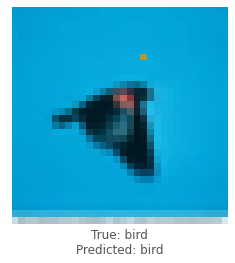

Attacking with target truck
1/1 [==============================] - 0s 17ms/step


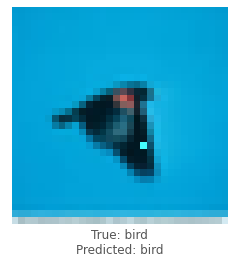


 resnet - image 492 - 4 / 10
Attacking with target airplane
1/1 [==============================] - 0s 28ms/step


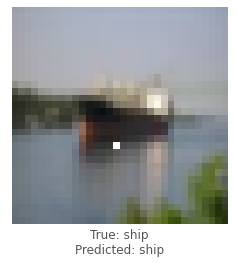

Attacking with target automobile
1/1 [==============================] - 0s 28ms/step


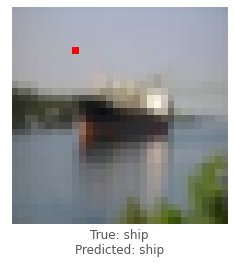

Attacking with target bird
1/1 [==============================] - 0s 25ms/step


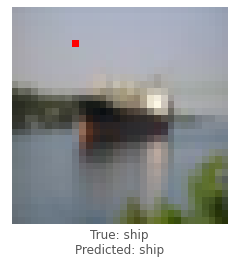

Attacking with target cat
1/1 [==============================] - 0s 22ms/step


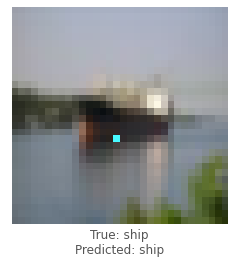

Attacking with target deer
1/1 [==============================] - 0s 21ms/step


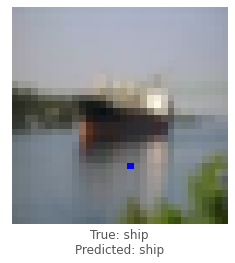

Attacking with target dog
1/1 [==============================] - 0s 24ms/step


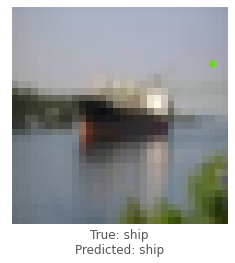

Attacking with target frog
1/1 [==============================] - 0s 23ms/step


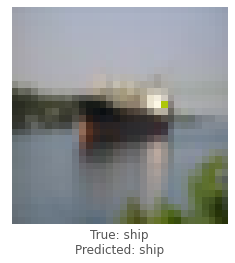

Attacking with target horse
1/1 [==============================] - 0s 29ms/step


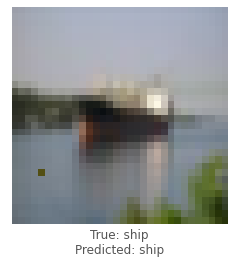

Attacking with target ship
Attacking with target truck
1/1 [==============================] - 0s 24ms/step


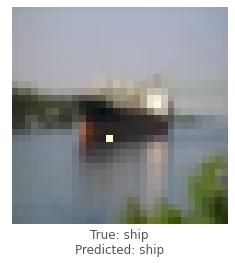


 resnet - image 6172 - 5 / 10
Attacking with target airplane
1/1 [==============================] - 0s 17ms/step


KeyboardInterrupt: ignored

In [ ]:
targeted = attack_all(models, samples=10, targeted=True,pixels=(1,))

### Attack Statistics

Print the final results! 

In [ ]:
# Load the results
untargeted, targeted = helper.load_results()

In [ ]:
columns = ['model', 'pixels', 'image', 'true', 'predicted', 'success', 'cdiff', 'prior_probs', 'predicted_probs', 'perturbation']
untargeted_results = pd.DataFrame(untargeted, columns=columns)
targeted_results = pd.DataFrame(targeted, columns=columns)

#### Untargeted

In [ ]:
helper.attack_stats(untargeted_results, models, network_stats)

#### Targeted

In [ ]:
helper.attack_stats(targeted_results, models, network_stats)

### Show some successful attacks

Plot 9 random successful attack images

Untargeted Attack


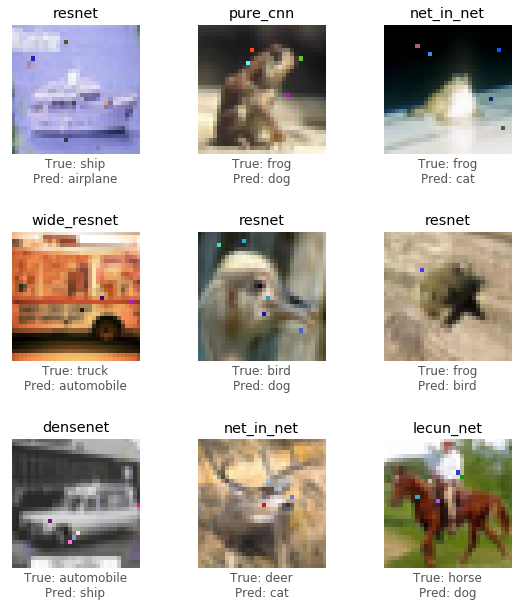

In [ ]:
print('Untargeted Attack')
helper.visualize_attack(untargeted_results, class_names)

Targeted Attack


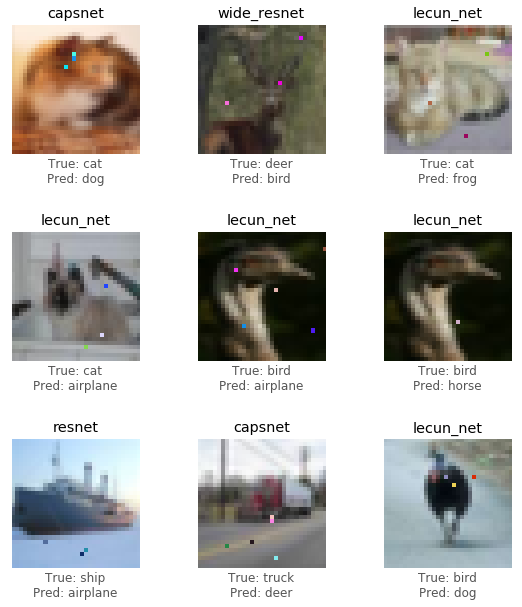

In [ ]:
print('Targeted Attack')
helper.visualize_attack(targeted_results, class_names)

## Conclusions

It appears that the accuracy of a model is not strongly correlated with the chance of performing a successful attack on an image. Perhaps surprisingly, the purely convolutional model is the most resistant CNN to these types of attacks. In addition, the capsule network CapsNet has the lowest attack success rate out of all the models, although it is still vulnerable to attack.

[Part 2](1_one-pixel-attack-cifar10.ipynb)

## Credits
 -  This implemenation is based off of the original paper describing the one pixel attack: https://arxiv.org/abs/1710.08864
 - Base code for iPython notebook: https://github.com/09rohanchopra/cifar10
 - Keras Cifar10 models: https://github.com/BIGBALLON/cifar-10-cnn
 - Scipy's differential evolution implementation: https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.differential_evolution.html
 - State of the art: https://github.com/RedditSota/state-of-the-art-result-for-machine-learning-problems
 - CapsNet Keras: https://github.com/XifengGuo/CapsNet-Keras
 - CapsNet with Cifar: https://github.com/theblackcat102/dynamic-routing-capsule-cifar